# Produce GAF Files for CNN

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from series2gaf import GenerateGAF, PlotHeatmap

%load_ext autoreload
%autoreload 2

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-ql0pm71b because the default path (/home/abriza/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


## Study on Producing GAF

In [3]:
data_path = "nasdaq-d.csv"
load_bars = 6000

df_full = (pd.read_csv(data_path, parse_dates=True)
  .drop(['Adj Close', 'Volume'], axis=1)
  .set_index('Date')
 )

df = df_full
df["Upper"] = df.apply(lambda x: x.High-x.Close if x.Close >= x.Open else x.High-x.Open, axis=1)
df["Lower"] = df.apply(lambda x: x.Open-x.Low if x.Open <= x.Close else x.Close-x.Low, axis=1)
df["RealBody"] = df.apply(lambda x: abs(x.Close-x.Open), axis=1)

df = df[-load_bars:]
print(df.shape)
df=df[:-1000]
df.tail()

(6000, 7)


,Open,High,Low,Close,Upper,Lower,RealBody
Date,,,,,,,
2018-03-29,6984.660156,7120.459961,6935.779785,7063.450195,57.009766,48.880371,78.790039
2018-04-02,7016.169922,7044.709961,6805.959961,6870.120117,28.540039,64.160156,146.049805
2018-04-03,6924.350098,6963.709961,6835.229980,6941.279785,22.430176,89.120118,16.929687
2018-04-04,6811.770020,7059.290039,6811.770020,7042.109863,17.180176,0.000000,230.339843
2018-04-05,7099.250000,7112.379883,7036.620117,7076.549805,13.129883,39.929688,22.700195


In [4]:
df.head()

,Open,High,Low,Close,Upper,Lower,RealBody
Date,,,,,,,
1998-05-22,1810.819946,1834.239990,1801.619995,1805.000000,23.420044,3.380005,5.819946
1998-05-26,1813.530029,1817.920044,1777.680054,1778.089966,4.390015,0.409912,35.440063
1998-05-27,1759.630005,1781.300049,1742.050049,1781.099976,0.200073,17.579956,21.469971
1998-05-28,1782.750000,1796.729980,1775.430054,1794.619995,2.109985,7.319946,11.869995
1998-05-29,1800.329956,1803.069946,1778.089966,1778.869995,2.739990,0.780029,21.459961


In [11]:
!ls

 cnn_example			   nasdaq-pch03
 Deep-GAF-CNN-RL		   nasdaq-pctchg03-classified
 demo_10_01_gaf.pkl		   nikkei_close_100s_10w_5r_gaf.pkl
 demo_20_02_gaf.pkl		   output_img
 demo_50_10_gaf.pkl		   output_img_nikkei
 GAF-CNN			   pch03.zip
 gaf_sample.png			  'Produce GAF files.ipynb'
'GAF Tony Sample.ipynb'		   __pycache__
 N225.csv			   README.md
 N225full.csv			   requirement.txt
 nasdaq15-w010-Close_gaf.pkl	   series2gaf.py
 nasdaq15-w010-Close.pkl_gaf.pkl   temp
 nasdaq-daily-1K		  'Tony Sample.ipynb'
 nasdaq-d.csv


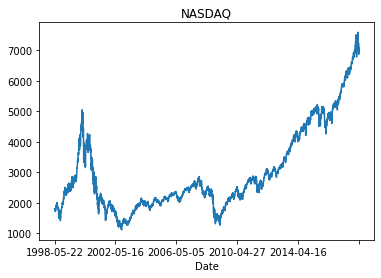

In [12]:
df.Close.plot(title="NASDAQ")
plt.savefig("../project/code/article_images/nasdaq_data.png")

In [25]:
n = df.shape[0]
moving_window_size = 10
rolling_length = 1
1 + int(np.floor((n - moving_window_size)/rolling_length))

4991

In [26]:
start_date = df.Close.index[0]
window_size = 10
col = "Open"
f"{start_date}-w{window_size:03}-{col}.pkl"

'1998-05-22-w010-Open.pkl'

## `generate_gaf` function

In [27]:
# Main function
from tqdm import trange
import os 

def generate_gaf(all_ts_series, window_size, rolling_length, output_dir, 
                normalize_window_scaling=1.0, method='summation', scale='[0,1]'):
    """ 
    Parameters
        all_ts_series : series, the entire timeseries source
        window_size : GAF window size
        rolling_length : number of steps?
        fname: filename to save to        
    """    
    os.makedirs(output_dir, exist_ok=True)     
    
    all_ts = all_ts_series.values
    
    # Get the length of the time series
    n = len(all_ts) 
    
    # We want to avoid overscaling the micro, so the moving window_size is a multiple of the original normalize_window_scaling
    moving_window_size = int(window_size * normalize_window_scaling)
    
    # Slice and dice the data into groups according to our scrolling size
    #. number of gaf entries we will make
    n_rolling_data = 1 + int(np.floor((n - moving_window_size)/rolling_length))
    
    # The final GAF
    #. gramian_field = []
    
    # Record the price, used to draw the graph
    #Prices = []

    # Start advancing from the first profile
    for i_rolling_data in trange(n_rolling_data, desc="Generating...", ascii=True):

         # Start position
        start_flag = i_rolling_data*rolling_length
        
         # The data of the whole pane is first taken from the input time series
        full_window_data =  list(all_ts[start_flag : start_flag+moving_window_size])
    
        #. if debugging/tracing 
        #. print(f"py range: {start_flag}, {start_flag+moving_window_size}")

        # Record the information of the window pane and use it to draw a picture
        #Prices.append(full_window_data[-int(window_size*(normalize_window_scaling-1)):])
        
        # Because we have to do cos/sin operation, so first normalize the time series
        rescaled_ts = np.zeros((moving_window_size, moving_window_size), float)
        min_ts, max_ts = np.min(full_window_data), np.max(full_window_data)
        if scale == '[0,1]':
            diff = max_ts - min_ts
            if diff != 0:
                rescaled_ts = (full_window_data - min_ts) / diff
        if scale == '[-1,1]':
            diff = max_ts - min_ts
            if diff != 0:
                rescaled_ts = (2 * full_window_data - diff) / diff

        # leave the original window_size length information
        rescaled_ts = rescaled_ts[-int(window_size*(normalize_window_scaling-1)):]
        
        # Calculate the Gramian Angular Matrix
        this_gam = np.zeros((window_size, window_size), float)
        sin_ts = np.sqrt(np.clip(1 - rescaled_ts**2, 0, 1))
        if method == 'summation':
            # cos(x1+x2) = cos(x1)cos(x2) - sin(x1)sin(x2)
            this_gam = np.outer(rescaled_ts, rescaled_ts) - np.outer(sin_ts, sin_ts)
        if method == 'difference':
            # sin(x1-x2) = sin(x1)cos(x2) - cos(x1)sin(x2)
            this_gam = np.outer(sin_ts, rescaled_ts) - np.outer(rescaled_ts, sin_ts)
                        
        #. gramian_field.append(this_gam)

        # save individual windows
        start_date =  all_ts_series.index[start_flag]  
        fname = f"{start_date}-w{window_size:03}-{col}.pkl"
        np.array(this_gam).dump(f'{output_dir}/{fname}')
            
        # Clear the memory footprint
        del this_gam
    
    #. # Output the gramian corner field
    #. np.array(gramian_field).dump('%s_gaf.pkl'%fname)

    # 1Clear memory footprint
    #. del gramian_field

## GAF with Folder Classifications

In [28]:
# Main function
from tqdm import trange
import os 

def generate_gaf_classifications(all_ts_series, window_size, rolling_length, output_dir, 
                normalize_window_scaling=1.0, method='summation', scale='[0,1]', 
                colname="Close", pct_change_target=0.03, delay=10):
    """ 
    Parameters
        all_ts_series : series, the entire timeseries source
        window_size : GAF window size
        rolling_length : number of steps?
        fname: filename to save to        
    """    
    os.makedirs(output_dir, exist_ok=True)  
    print("Saving to: %s" % output_dir)
    for s in ['test', 'validation', 'train']:
        for k in ['up', 'down', 'side']:
            os.makedirs(f"{output_dir}/{s}/{k}", exist_ok=True)
        
    n_up = 0
    n_dn = 0
    n_sd = 0
    
    
    all_ts = all_ts_series.values
    
    # Get the length of the time series
    n = len(all_ts) 
    
    # We want to avoid overscaling the micro, so the moving window_size is a multiple of the original normalize_window_scaling
    moving_window_size = int(window_size * normalize_window_scaling)
    
    # Slice and dice the data into groups according to our scrolling size
    #. number of gaf entries we will make
    n_rolling_data = 1 + int(np.floor((n - moving_window_size)/rolling_length))
    
    # The final GAF
    #. gramian_field = []
    
    # Record the price, used to draw the graph
    #Prices = []

    # Start advancing from the first profile
    for i_rolling_data in trange(n_rolling_data, desc="Generating...", ascii=True):

         # Start position
        start_flag = i_rolling_data*rolling_length
        
         # The data of the whole pane is first taken from the input time series
        full_window_data =  list(all_ts[start_flag : start_flag+moving_window_size])
    
        #. if debugging/tracing 
        #. print(f"py range: {start_flag}, {start_flag+moving_window_size}")

        # Record the information of the window pane and use it to draw a picture
        #Prices.append(full_window_data[-int(window_size*(normalize_window_scaling-1)):])
        
        # Because we have to do cos/sin operation, so first normalize the time series
        rescaled_ts = np.zeros((moving_window_size, moving_window_size), float)
        min_ts, max_ts = np.min(full_window_data), np.max(full_window_data)
        if scale == '[0,1]':
            diff = max_ts - min_ts
            if diff != 0:
                rescaled_ts = (full_window_data - min_ts) / diff
        if scale == '[-1,1]':
            diff = max_ts - min_ts
            if diff != 0:
                rescaled_ts = (2 * full_window_data - diff) / diff

        # leave the original window_size length information
        rescaled_ts = rescaled_ts[-int(window_size*(normalize_window_scaling-1)):]
        
        # Calculate the Gramian Angular Matrix
        this_gam = np.zeros((window_size, window_size), float)
        sin_ts = np.sqrt(np.clip(1 - rescaled_ts**2, 0, 1))
        if method == 'summation':
            # cos(x1+x2) = cos(x1)cos(x2) - sin(x1)sin(x2)
            this_gam = np.outer(rescaled_ts, rescaled_ts) - np.outer(sin_ts, sin_ts)
        if method == 'difference':
            # sin(x1-x2) = sin(x1)cos(x2) - cos(x1)sin(x2)
            this_gam = np.outer(sin_ts, rescaled_ts) - np.outer(rescaled_ts, sin_ts)
                        
        #. gramian_field.append(this_gam)

        # compute percent change
        window_end_index = start_flag+moving_window_size-1
        
        # don't continue if target date for percent change is beyond the data
        target_index = window_end_index+delay # index of price tobe targetted
        if target_index >= n:
            continue
        
        window_end_price = all_ts[window_end_index]
        target_price = all_ts[target_index]        
        pct_change = (target_price-window_end_price)/window_end_price
        
        if pct_change >= pct_change_target:
            classdir= "up"
            n_up += 1
        elif pct_change <= -pct_change_target:
            classdir= "down"
            n_dn += 1
        else:
            classdir= "side"
            n_sd += 1
            
        if start_flag > n - 1000 - 2*delay:
            split_dir = "test"
        elif start_flag > n - 2000 - 2*delay:
            split_dir = "validation"
        else:
            split_dir = "train"
        
                        
        # save individual windows        
        start_date =  all_ts_series.index[start_flag]  
        
        fname = f"{start_date}-w{window_size:03}-{colname}-{classdir}-ch{pct_change:.3f}.png"        
        plt.imshow(this_gam, cmap='hot', interpolation='nearest')
        plt.axis('off')
        plt.savefig(f'{output_dir}/{split_dir}/{classdir}/{fname}', bbox_inches='tight', pad_inches=0, transparent=True)
        plt.clf()        
        
        # np.array(this_gam).dump(f'{output_dir}/{subdir}/{fname}')
            
        # Clear the memory footprint
        del this_gam
    
    print(f"Up: {n_up}; Down: {n_dn}; Side:{n_sd})")
    #. # Output the gramian corner field
    #. np.array(gramian_field).dump('%s_gaf.pkl'%fname)

    # 1Clear memory footprint
    #. del gramian_field

### Generate sample GAF by classifications

In [29]:
col = "Close"
output_dir = "/home/phd/abriza/dla/project/code/data/gaf-nasdaq-pch03-1Kbackward"
generate_gaf_classifications(
    all_ts_series = df[col],
    window_size = 10,
    rolling_length = 1,
    output_dir = output_dir,
    colname="Close",
    pct_change_target=0.03, 
    delay=10)

Saving to: /home/phd/abriza/dla/project/code/data/gaf-nasdaq-pch03-1Kbackward


Generating...: 100%|##########| 4991/4991 [05:00<00:00, 16.60it/s]

Up: 1219; Down: 896; Side:2866)


<Figure size 432x288 with 0 Axes>

# CULR GAF

## Study

In [35]:
a= np.random.randint(10, size=(4, 4))
a

array([[6, 8, 3, 3],
       [4, 7, 0, 6],
       [1, 1, 8, 7],
       [4, 3, 9, 0]])

In [48]:
a.T.reshape(-1)

array([6, 4, 1, 4, 8, 7, 1, 3, 3, 0, 8, 9, 3, 6, 7, 0])

In [50]:
a.reshape(-1, order='F')

array([6, 4, 1, 4, 8, 7, 1, 3, 3, 0, 8, 9, 3, 6, 7, 0])

In [42]:
df.iloc[0:4]

,Open,High,Low,Close,Upper,Lower,RealBody
Date,,,,,,,
1998-05-22,1810.819946,1834.239990,1801.619995,1805.000000,23.420044,3.380005,5.819946
1998-05-26,1813.530029,1817.920044,1777.680054,1778.089966,4.390015,0.409912,35.440063
1998-05-27,1759.630005,1781.300049,1742.050049,1781.099976,0.200073,17.579956,21.469971
1998-05-28,1782.750000,1796.729980,1775.430054,1794.619995,2.109985,7.319946,11.869995


In [47]:
df.iloc[0:4].values.reshape()

(4, 7)

In [55]:
df.RealBody

Date
1998-05-22      5.819946
1998-05-26     35.440063
1998-05-27     21.469971
1998-05-28     11.869995
1998-05-29     21.459961
                 ...    
2018-03-29     78.790039
2018-04-02    146.049805
2018-04-03     16.929687
2018-04-04    230.339843
2018-04-05     22.700195
Name: RealBody, Length: 5000, dtype: float64

##  generate_culr_gaf_classifications

In [66]:
#  CULR GAF
from tqdm import trange
import os 

def generate_culr_gaf_classifications(df, window_size, rolling_length, output_dir, 
                normalize_window_scaling=1.0, method='summation', scale='[0,1]', pct_change_target=0.03, delay=10):
    """ 
    Parameters
        all_ts_series : series, the entire timeseries source
        window_size : GAF window size
        rolling_length : number of steps?
        fname: filename to save to        
    """    
    
    
    os.makedirs(output_dir, exist_ok=True)  
    print("Saving to: %s" % output_dir)
    for s in ['test', 'validation', 'train']:
        for k in ['up', 'down', 'side']:
            os.makedirs(f"{output_dir}/{s}/{k}", exist_ok=True)
        
    n_up = 0
    n_dn = 0
    n_sd = 0


    # Get the length of the time series
    n = df.shape[0]  #len(all_ts) 

    # We want to avoid overscaling the micro, so the moving window_size is a multiple of the original normalize_window_scaling
    moving_window_size = int(window_size * normalize_window_scaling)

    # Slice and dice the data into groups according to our scrolling size
    #. number of gaf entries we will make
    n_rolling_data = 1 + int(np.floor((n - moving_window_size)/rolling_length))

    # Start advancing from the first profile
    for i_rolling_data in trange(n_rolling_data, desc="Generating...", ascii=True):

        # compute gaf per column
        gam_bag = {}
        for col in ["Close", "Upper", "Lower", "RealBody"]:
            all_ts = df[col].values
        
             # Start position
            start_flag = i_rolling_data*rolling_length

             # The data of the whole pane is first taken from the input time series
            full_window_data =  list(all_ts[start_flag : start_flag+moving_window_size])

            # Because we have to do cos/sin operation, so first normalize the time series
            rescaled_ts = np.zeros((moving_window_size, moving_window_size), float)
            min_ts, max_ts = np.min(full_window_data), np.max(full_window_data)
            if scale == '[0,1]':
                diff = max_ts - min_ts
                if diff != 0:
                    rescaled_ts = (full_window_data - min_ts) / diff
            if scale == '[-1,1]':
                diff = max_ts - min_ts
                if diff != 0:
                    rescaled_ts = (2 * full_window_data - diff) / diff

            # leave the original window_size length information
            rescaled_ts = rescaled_ts[-int(window_size*(normalize_window_scaling-1)):]

            # Calculate the Gramian Angular Matrix
            this_gam = np.zeros((window_size, window_size), float)
            sin_ts = np.sqrt(np.clip(1 - rescaled_ts**2, 0, 1))
            if method == 'summation':
                # cos(x1+x2) = cos(x1)cos(x2) - sin(x1)sin(x2)
                this_gam = np.outer(rescaled_ts, rescaled_ts) - np.outer(sin_ts, sin_ts)
            if method == 'difference':
                # sin(x1-x2) = sin(x1)cos(x2) - cos(x1)sin(x2)
                this_gam = np.outer(sin_ts, rescaled_ts) - np.outer(rescaled_ts, sin_ts)

            # save gam for column    
            gam_bag[col] = this_gam

            # Clear the memory footprint
            del this_gam     
            
        culr_gam = np.vstack((
                np.hstack((gam_bag["Close"], gam_bag["RealBody"])), 
                np.hstack((gam_bag["Upper"], gam_bag["Lower"])) 
            ))

        # compute percent change
        window_end_index = start_flag+moving_window_size-1

        # don't continue if target date for percent change is beyond the data
        target_index = window_end_index+delay # index of price tobe targetted
        if target_index >= n:
            continue

        window_end_price = df.Close[window_end_index]
        target_price = df.Close[target_index]        
        pct_change = (target_price-window_end_price)/window_end_price

        if pct_change >= pct_change_target:
            classdir= "up"
            n_up += 1
        elif pct_change <= -pct_change_target:
            classdir= "down"
            n_dn += 1
        else:
            classdir= "side"
            n_sd += 1

        if start_flag > n - 1000 - 2*delay:
            split_dir = "test"
        elif start_flag > n - 2000 - 2*delay:
            split_dir = "validation"
        else:
            split_dir = "train"


        # save individual windows        
        start_date =  df.index[start_flag]  

        fname = f"{start_date}-w{window_size:03}-CULR-{classdir}-ch{pct_change:.3f}.png"        
        plt.imshow(culr_gam, cmap='hot', interpolation='nearest')
        plt.axis('off')
        plt.savefig(f'{output_dir}/{split_dir}/{classdir}/{fname}', bbox_inches='tight', pad_inches=0, transparent=True)
        plt.clf()        
                  
    print(f"Up: {n_up}; Down: {n_dn}; Side:{n_sd})")


## Generate CULR GAF

In [67]:
col = "Close"
output_dir = "/home/phd/abriza/dla/project/code/data/gaf-culr-nasdaq-pch03-1Kbackward"
generate_culr_gaf_classifications(
    df = df,
    window_size = 10,
    rolling_length = 1,
    output_dir = output_dir,
    pct_change_target=0.03, 
    delay=10)

Saving to: /home/phd/abriza/dla/project/code/data/gaf-culr-nasdaq-pch03-1Kbackward


Generating...: 100%|##########| 4991/4991 [05:06<00:00, 16.29it/s]

Up: 1219; Down: 896; Side:2866)


<Figure size 432x288 with 0 Axes>

# OHLC GAF

## generate_ohlc_gaf_classifications

In [68]:
#  OHLC GAF
from tqdm import trange
import os 

def generate_ohlc_gaf_classifications(df, window_size, rolling_length, output_dir, 
                normalize_window_scaling=1.0, method='summation', scale='[0,1]', pct_change_target=0.03, delay=10):
    """ 
    Parameters
        all_ts_series : series, the entire timeseries source
        window_size : GAF window size
        rolling_length : number of steps?
        fname: filename to save to        
    """    
    
    
    os.makedirs(output_dir, exist_ok=True)  
    print("Saving to: %s" % output_dir)
    for s in ['test', 'validation', 'train']:
        for k in ['up', 'down', 'side']:
            os.makedirs(f"{output_dir}/{s}/{k}", exist_ok=True)
        
    n_up = 0
    n_dn = 0
    n_sd = 0


    # Get the length of the time series
    n = df.shape[0]  #len(all_ts) 

    # We want to avoid overscaling the micro, so the moving window_size is a multiple of the original normalize_window_scaling
    moving_window_size = int(window_size * normalize_window_scaling)

    # Slice and dice the data into groups according to our scrolling size
    #. number of gaf entries we will make
    n_rolling_data = 1 + int(np.floor((n - moving_window_size)/rolling_length))

    # Start advancing from the first profile
    for i_rolling_data in trange(n_rolling_data, desc="Generating...", ascii=True):

        # compute gaf per column
        gam_bag = {}
        for col in ["Open", "High", "Low", "Close"]:
            all_ts = df[col].values
        
             # Start position
            start_flag = i_rolling_data*rolling_length

             # The data of the whole pane is first taken from the input time series
            full_window_data =  list(all_ts[start_flag : start_flag+moving_window_size])

            # Because we have to do cos/sin operation, so first normalize the time series
            rescaled_ts = np.zeros((moving_window_size, moving_window_size), float)
            min_ts, max_ts = np.min(full_window_data), np.max(full_window_data)
            if scale == '[0,1]':
                diff = max_ts - min_ts
                if diff != 0:
                    rescaled_ts = (full_window_data - min_ts) / diff
            if scale == '[-1,1]':
                diff = max_ts - min_ts
                if diff != 0:
                    rescaled_ts = (2 * full_window_data - diff) / diff

            # leave the original window_size length information
            rescaled_ts = rescaled_ts[-int(window_size*(normalize_window_scaling-1)):]

            # Calculate the Gramian Angular Matrix
            this_gam = np.zeros((window_size, window_size), float)
            sin_ts = np.sqrt(np.clip(1 - rescaled_ts**2, 0, 1))
            if method == 'summation':
                # cos(x1+x2) = cos(x1)cos(x2) - sin(x1)sin(x2)
                this_gam = np.outer(rescaled_ts, rescaled_ts) - np.outer(sin_ts, sin_ts)
            if method == 'difference':
                # sin(x1-x2) = sin(x1)cos(x2) - cos(x1)sin(x2)
                this_gam = np.outer(sin_ts, rescaled_ts) - np.outer(rescaled_ts, sin_ts)

            # save gam for column    
            gam_bag[col] = this_gam

            # Clear the memory footprint
            del this_gam     
            
        ohlc_gam = np.vstack((
                np.hstack((gam_bag["Open"], gam_bag["Close"])), 
                np.hstack((gam_bag["Low"], gam_bag["High"])) 
            ))

        # compute percent change
        window_end_index = start_flag+moving_window_size-1

        # don't continue if target date for percent change is beyond the data
        target_index = window_end_index+delay # index of price tobe targetted
        if target_index >= n:
            continue

        window_end_price = df.Close[window_end_index]
        target_price = df.Close[target_index]        
        pct_change = (target_price-window_end_price)/window_end_price

        if pct_change >= pct_change_target:
            classdir= "up"
            n_up += 1
        elif pct_change <= -pct_change_target:
            classdir= "down"
            n_dn += 1
        else:
            classdir= "side"
            n_sd += 1

        if start_flag > n - 1000 - 2*delay:
            split_dir = "test"
        elif start_flag > n - 2000 - 2*delay:
            split_dir = "validation"
        else:
            split_dir = "train"


        # save individual windows        
        start_date =  df.index[start_flag]  

        fname = f"{start_date}-w{window_size:03}-OHLC-{classdir}-ch{pct_change:.3f}.png"        
        plt.imshow(ohlc_gam, cmap='hot', interpolation='nearest')
        plt.axis('off')
        plt.savefig(f'{output_dir}/{split_dir}/{classdir}/{fname}', bbox_inches='tight', pad_inches=0, transparent=True)
        plt.clf()        
                  
    print(f"Up: {n_up}; Down: {n_dn}; Side:{n_sd})")


## Generate OHLC GAF

In [70]:
col = "Close"
output_dir = "/home/phd/abriza/dla/project/code/data/gaf-ohlc-nasdaq-pch03-1Kbackward"
generate_ohlc_gaf_classifications(
    df = df,
    window_size = 10,
    rolling_length = 1,
    output_dir = output_dir,
    pct_change_target=0.03, 
    delay=10)

Saving to: /home/phd/abriza/dla/project/code/data/gaf-ohlc-nasdaq-pch03-1Kbackward


Generating...: 100%|##########| 4991/4991 [05:16<00:00, 15.77it/s]

Up: 1219; Down: 896; Side:2866)


<Figure size 432x288 with 0 Axes>

# Generate sample GAF (Orig)

In [ ]:
col = "Close"
output_dir = "nasdaq-daily-1K"
generate_gaf(
    all_ts_series = df[col],
    window_size = 10,
    rolling_length = 1,
    output_dir = output_dir)

In [ ]:
def PlotHeatmap(all_img):
    # Get the total length of the data
    total_length = all_img.shape[0]

    # Output image
    for img_no in trange(total_length, desc="Output Heatmaps...", ascii=True):
        
        this_fname = str(img_no).zfill(fname_zero_padding_size)
        
        plt.imshow(all_img[img_no], cmap='hot', interpolation='nearest')
        plt.axis('off')
        plt.savefig("%s/%s.png"%(save_dir, this_fname), bbox_inches='tight', pad_inches=0, transparent=True)
        plt.clf()


In [ ]:
nasdaq15_gaf = np.load("nasdaq15-w010-Close_gaf.pkl", allow_pickle=True)
PlotHeatmap(nasdaq15_gaf, save_dir='temp')

### Load a sample GAF

In [92]:
sample =  np.load(f"{output_dir}/2022-03-04-w010-Close.pkl", allow_pickle=True)
sample.shape, sample

((10, 10),
 array([[ 0.00378837, -0.51367078, -0.54351385, -0.07264812, -0.2219516 ,
         -0.50261835, -0.70576612, -0.40783941,  0.19007404,  0.70844491],
        [-0.51367078, -0.88322895, -0.89916763, -0.57774094, -0.69402274,
         -0.87713852, -0.97036822, -0.8210983 , -0.34478386,  0.24163097],
        [-0.54351385, -0.89916763, -0.91399486, -0.60607618, -0.71890207,
         -0.89347803, -0.97826246, -0.8406555 , -0.37756794,  0.20737061],
        [-0.07264812, -0.57774094, -0.60607618, -0.14865966, -0.29582217,
         -0.56721921, -0.75784552, -0.47642758,  0.11448543,  0.65243404],
        [-0.2219516 , -0.69402274, -0.71890207, -0.29582217, -0.43624325,
         -0.68472679, -0.84742057, -0.60334615, -0.03635834,  0.5309222 ],
        [-0.50261835, -0.87713852, -0.89347803, -0.56721921, -0.68472679,
         -0.87090364, -0.96718758, -0.81370606, -0.33270982,  0.25406334],
        [-0.70576612, -0.97036822, -0.97826246, -0.75784552, -0.84742057,
         -0.96718758,

### Show sample as Image

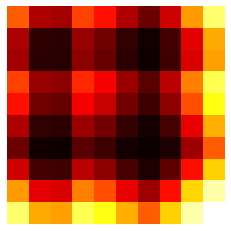

In [93]:
from matplotlib import pyplot as plt
plt.imshow(sample, cmap='hot', interpolation='nearest')
plt.axis('off');

### Check if output is the same when using the package

In [94]:
GenerateGAF(all_ts = df.Close,
            window_size = 10,
            rolling_length = 1,
            fname = "nasdaq15-w010-Close")

Generating...: 100%|##########| 6/6 [00:00<00:00, 3524.13it/s]

Saved nasdaq15-w010-Close_gaf.pkl


In [95]:
nasdaq15_gaf = np.load("nasdaq15-w010-Close_gaf.pkl", allow_pickle=True)
PlotHeatmap(nasdaq15_gaf, save_dir='temp')

Output Heatmaps...: 100%|##########| 6/6 [00:00<00:00, 14.07it/s]


<Figure size 432x288 with 0 Axes>

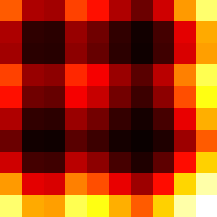

In [96]:
from IPython import display
display.Image("temp/0.png")

# Create GAF pkl files for 1K data of nasdaq

In [97]:
data_path = "nasdaq-d.csv"
load_bars = 1000

df_full = (pd.read_csv(data_path, parse_dates=True)
  .drop(['Adj Close', 'Volume'], axis=1)
  .set_index('Date')
 )
df_full["Upper"] = df.apply(lambda x: x.High-x.Close if x.Close >= x.Open else x.High-x.Open, axis=1)
df_full["Lower"] = df.apply(lambda x: x.Open-x.Low if x.Open <= x.Close else x.Close-x.Low, axis=1)
df_full["RealBody"] = df.apply(lambda x: abs(x.Close-x.Open), axis=1)

df1K = df_full[-load_bars:]
print(df1K.shape)
df1K.head()

(1000, 7)


,Open,High,Low,Close,Upper,Lower,RealBody
Date,,,,,,,
2018-04-06,6999.569824,7066.640137,6877.759766,6915.109863,NaN,NaN,NaN
2018-04-09,6971.450195,7074.950195,6944.959961,6950.339844,NaN,NaN,NaN
2018-04-10,7060.990234,7117.979980,7014.879883,7094.299805,NaN,NaN,NaN
2018-04-11,7055.000000,7128.540039,7055.000000,7069.029785,NaN,NaN,NaN
2018-04-12,7112.020020,7166.000000,7105.089844,7140.250000,NaN,NaN,NaN


In [98]:
output_dir = "nasdaq-daily-1K"
cols = ['Open', 'High', 'Low', 'Close', 'Upper', 'Lower', 'RealBody']
for col in cols:
    generate_gaf(
        all_ts_series = df1K[col],
        window_size = 10,
        rolling_length = 1,
        output_dir = output_dir)

Generating...: 100%|##########| 991/991 [00:01<00:00, 942.36it/s] 


#### Count the number of files in outputdir

In [99]:
!ls  nasdaq-daily-1K | wc -l

6937


In [145]:
# number of windows
6937 /len(cols)

991.0

## `get_gaf` function

In [139]:
gaf = np.zeros( (window_size**2, 4)) 
gaf.shape

(100, 4)

In [140]:
gaf.reshape(-1).shape

(400,)

In [141]:
idx = 1
start_date = df1K.index[idx]
start_date

'2018-04-09'

In [142]:
data_cols = ['Open', 'High', 'Low', 'Close']
output_dir = "nasdaq-daily-1K"
for i, col in enumerate(data_cols):
    col_file = f"{start_date}-w{window_size:03}-{col}.pkl"
    # load pkl; reshape to 1x100 vector
    col_gaf = np.load(f"{output_dir}/{col_file}", allow_pickle=True)
    col_gaf = col_gaf.reshape(-1)
    gaf[:, i] = col_gaf    

In [138]:
gaf.shape

(100, 4)

In [143]:
gaf[:,0]

array([-1.        , -0.96029051, -0.96551787, -0.89897099, -0.76108981,
       -0.82274485, -0.65078433,  0.        , -0.44651851, -0.63016318,
       -0.96029051, -0.84431572, -0.85454315, -0.74106814, -0.54989362,
       -0.63148628, -0.41310619,  0.27900204, -0.1791436 , -0.38850503,
       -0.96551787, -0.85454315, -0.86444951, -0.75394292, -0.56597926,
       -0.64639659, -0.4306799 ,  0.26033679, -0.1981789 , -0.40629199,
       -0.89897099, -0.74106814, -0.75394292, -0.61629769, -0.4000852 ,
       -0.49065515, -0.252473  ,  0.43800817, -0.00948869, -0.2264014 ,
       -0.76108981, -0.54989362, -0.56597926, -0.4000852 , -0.15851541,
       -0.257485  , -0.00281226,  0.64864651,  0.2405516 ,  0.02403907,
       -0.82274485, -0.63148628, -0.64639659, -0.49065515, -0.257485  ,
       -0.35381817, -0.10385632,  0.56841087,  0.14122869, -0.07711365,
       -0.65078433, -0.41310619, -0.4306799 , -0.252473  , -0.00281226,
       -0.10385632,  0.15295951,  0.75926264,  0.38878152,  0.17

In [148]:
def get_gaf(gaf_dir, idx, data_cols, window_size):
    gaf = np.zeros((window_size**2, 4)) 
    start_date = df1K.index[idx] 
    print(start_date)
    for i, col in enumerate(data_cols):
        col_file = f"{start_date}-w{window_size:03}-{col}.pkl"
        # load pkl; reshape to 1x100 vector
        col_gaf = np.load(f"{gaf_dir}/{col_file}", allow_pickle=True)
        col_gaf = col_gaf.reshape(-1)
        gaf[:, i] = col_gaf  
    return gaf

#### Check

In [151]:
data_cols = ['Open', 'High', 'Low', 'Close']
idx = 991 - 1 
window_size = 10
sample_gaf = get_gaf("nasdaq-daily-1K", idx, data_cols, window_size)

2022-03-11


In [165]:
sample_gaf.shape

(100, 4)

In [171]:
sampe_gaf_block = sample_gaf.T[3].reshape((10,10))
sampe_gaf_block

array([[-0.94571498, -0.98633538, -0.9217975 , -0.74387177, -0.64401318,
        -0.42382443, -0.47630037, -0.12355463, -0.39409023,  0.16474984],
       [-0.98633538, -1.        , -0.97307034, -0.84381305, -0.76124898,
        -0.56725427, -0.61465358, -0.28535379, -0.54012206,  0.        ],
       [-0.9217975 , -0.97307034, -0.89373179, -0.69739008, -0.59127342,
        -0.36214482, -0.41627683, -0.05674497, -0.33158399,  0.23050836],
       [-0.74387177, -0.84381305, -0.69739008, -0.42404092, -0.29436419,
        -0.03671286, -0.09535477,  0.27353983, -0.00413527,  0.53663725],
       [-0.64401318, -0.76124898, -0.59127342, -0.29436419, -0.15900002,
         0.10221253,  0.04359876,  0.40427293,  0.13456769,  0.64845971],
       [-0.42382443, -0.56725427, -0.36214482, -0.03671286,  0.10221253,
         0.35644519,  0.30094329,  0.6274335 ,  0.38669605,  0.82354271],
       [-0.47630037, -0.61465358, -0.41627683, -0.09535477,  0.04359876,
         0.30094329,  0.24440194,  0.58060702

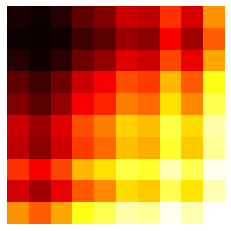

In [172]:
plt.imshow(sampe_gaf_block, cmap='hot', interpolation='nearest')
plt.axis('off');

In [173]:
pkl_file = f"2022-03-11-w{window_size:03}-Close.pkl"
gaf_dir = "nasdaq-daily-1K"
from_pkl = np.load(f"{gaf_dir}/{pkl_file}", allow_pickle=True)
from_pkl

array([[-0.94571498, -0.98633538, -0.9217975 , -0.74387177, -0.64401318,
        -0.42382443, -0.47630037, -0.12355463, -0.39409023,  0.16474984],
       [-0.98633538, -1.        , -0.97307034, -0.84381305, -0.76124898,
        -0.56725427, -0.61465358, -0.28535379, -0.54012206,  0.        ],
       [-0.9217975 , -0.97307034, -0.89373179, -0.69739008, -0.59127342,
        -0.36214482, -0.41627683, -0.05674497, -0.33158399,  0.23050836],
       [-0.74387177, -0.84381305, -0.69739008, -0.42404092, -0.29436419,
        -0.03671286, -0.09535477,  0.27353983, -0.00413527,  0.53663725],
       [-0.64401318, -0.76124898, -0.59127342, -0.29436419, -0.15900002,
         0.10221253,  0.04359876,  0.40427293,  0.13456769,  0.64845971],
       [-0.42382443, -0.56725427, -0.36214482, -0.03671286,  0.10221253,
         0.35644519,  0.30094329,  0.6274335 ,  0.38669605,  0.82354271],
       [-0.47630037, -0.61465358, -0.41627683, -0.09535477,  0.04359876,
         0.30094329,  0.24440194,  0.58060702

In [174]:
sampe_gaf_block == from_pkl

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True]])

# Incorporated Version

In [ ]:
def get_gaf_embedding(gaf_dir, idx, data_cols, window_size):
    gaf = np.zeros((window_size**2, 4)) 
    start_date = df1K.index[idx] 
    print(start_date)
    for i, col in enumerate(data_cols):
        col_file = f"{start_date}-w{window_size:03}-{col}.pkl"
        # load pkl; reshape to 1x100 vector
        col_gaf = np.load(f"{gaf_dir}/{col_file}", allow_pickle=True)
        col_gaf = col_gaf.reshape(-1)
        gaf[:, i] = col_gaf  
    return gaf